In [1]:
import sys
sys.path.append('..')

import numpy as np
import os
from time import time
from collections import Counter
import random
from matplotlib import pyplot as plt

from lib.data_utils import shuffle
#from lib.config import data_dir

def mnist():
    fd = open(os.path.join('train-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    trX = loaded[16:].reshape((60000,28*28)).astype(float)

    fd = open(os.path.join('train-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    trY = loaded[8:].reshape((60000))

    fd = open(os.path.join('t10k-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    teX = loaded[16:].reshape((10000,28*28)).astype(float)

    fd = open(os.path.join('t10k-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    teY = loaded[8:].reshape((10000))
    
    trY = np.asarray(trY)
    teY = np.asarray(teY)

    return trX, teX, trY, teY

def mnist_with_valid_set():
    trX, teX, trY, teY = mnist()

    trX, trY = shuffle(trX, trY)
    vaX = trX[50000:]
    vaY = trY[50000:]
    trX = trX[:50000]
    trY = trY[:50000]

    return trX, vaX, teX, trY, vaY, teY

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmp01tu4p/265abc51f7c376c224983485238ff1a5.lib and object C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmp01tu4p/265abc51f7c376c224983485238ff1a5.exp

Using gpu device 0: Quadro K2000 (CNMeM is disabled, cuDNN 5005)


In [2]:
#data_dir='/home/dcgan_code-master/mnist'
import theano
theano.config.floatX='float32'
theano.config.floatX

'float32'

In [3]:
trX, vaX, teX, trY, vaY, teY = mnist_with_valid_set()
import cv2
data2=np.zeros((1000,64*64))
trX=trX
%matplotlib inline
for i in range(1000):
    XXX=trX[i,:].reshape(28,28)
    temp=cv2.resize(XXX,(64,64))
    #temp[temp>=0.5]=1
    #temp[temp<=0.5]=0
    temp=temp.reshape(-1)
    data2[i,:]=np.round(temp/max(temp)*255.)

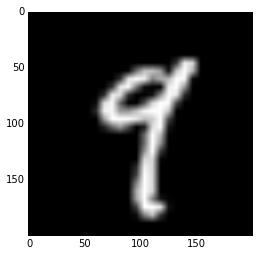

In [79]:
np.set_printoptions(threshold='nan')
plt.imshow(data2[0].reshape(200,200),'gray')
#plt.imshow(trX[0].reshape(28,28),'gray')

In [3]:
import numpy as np
import theano
import theano.tensor as tensor
from theano.tensor.signal.pool import pool_2d
from theano.tensor.nnet import conv2d

def conv( x, w, b=None ):
    s = int(np.floor(w.get_value().shape[-1]/2.))
    z = conv2d(x, w, border_mode='full')[:, :, s:-s, s:-s]
    if b is not None:
        z += b.dimshuffle('x', 0, 'x', 'x')
    
    return z
        
def max_pool( x, size, ignore_border=False ):
    return pool_2d( x, size, ignore_border=ignore_border )

def rectify( x ):
    return (x + abs(x)) / 2.0

def batchnorm( x, g=None, b=None, eps=1e-8 ):
    if x.ndim == 4:
        m = tensor.mean(x, axis=[0, 2, 3]).dimshuffle('x', 0, 'x', 'x')
        v = tensor.mean(tensor.sqr(x - m), 
                          axis=[0, 2, 3]).dimshuffle('x', 0, 'x', 'x')

        x = (x - m) / tensor.sqrt( v + eps )
        if g is not None and b is not None:
            x = x*g.dimshuffle('x', 0, 'x', 'x') + b.dimshuffle('x', 0, 'x', 'x')

    elif x.ndim == 2:
        m = tensor.mean(x, axis=0)
        v = tensor.mean(tensor.sqr(x - m), axis=0)

        x = (x - m) / tensor.sqrt( v + eps )
        if g is not None and b is not None:
            x = x*g + b

    return x

def depool( x, factor=2 ):
    """
    This code is from 
    https://gist.github.com/kastnerkyle/f3f67424adda343fef40
    """
    output_shape = [
        x.shape[1],
        x.shape[2]*factor,
        x.shape[3]*factor
    ]
    stride = x.shape[2]
    offset = x.shape[3]
    in_dim = stride * offset
    out_dim = in_dim * factor * factor

    upsamp_matrix = tensor.zeros((in_dim, out_dim))
    rows = tensor.arange(in_dim)
    cols = rows*factor + (rows/stride * factor * offset)
    upsamp_matrix = tensor.set_subtensor(upsamp_matrix[rows, cols], 1.)

    flat = tensor.reshape(x, (x.shape[0], output_shape[0], x.shape[2] * x.shape[3]))

    up_flat = tensor.dot(flat, upsamp_matrix)
    upsamp = tensor.reshape(up_flat, (x.shape[0], output_shape[0],
                                      output_shape[1], output_shape[2]))

    return upsamp

def full_conn( x, w, b=None ):
    return tensor.dot( x, w ) + b

def leaky_rectify( x, leak=0.2 ):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * x + f2 * abs(x) 

In [4]:
trX, vaX, teX, trY, vaY, teY = mnist_with_valid_set()
np.set_printoptions(threshold='nan')

In [5]:
import sys
sys.path.append('..')

import os
import json
from time import time
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.externals import joblib

import theano
import theano.tensor as T
from theano.sandbox.cuda.dnn import dnn_conv

from lib import activations
from lib import updates
from lib import inits
from lib.vis import grayscale_grid_vis
from lib.rng import py_rng, np_rng
from lib.ops import batchnorm, conv_cond_concat, deconv, dropout
from lib.theano_utils import floatX, sharedX
from lib.data_utils import OneHot, shuffle, iter_data
from lib.metrics import nnc_score, nnd_score

trX, vaX, teX, trY, vaY, teY = mnist_with_valid_set()

#trX=data2
trX = trX[0:1000]
vaX = floatX(vaX[0:1000])/255.

k = 1             # # of discrim updates for each gen update
l2 = 2.5e-5       # l2 weight decay
b1 = 0.5          # momentum term of adam
nc = 1            # # of channels in image
ny = 10           # # of classes
nbatch = 100      # # of examples in batch
npx = 28          # # of pixels width/height of images
nz = 100          # # of dim for Z
ngfc = 1024       # # of gen units for fully connected layers
ndfc = 1024       # # of discrim units for fully connected layers
ngf = 64          # # of gen filters in first conv layer
ndf = 64          # # of discrim filters in first conv layer
nx = npx*npx*nc   # # of dimensions in X
niter = 100       # # of iter at starting learning rate
niter_decay = 100 # # of iter to linearly decay learning rate to zero
lr = 0.0002       # initial learning rate for adam
ntrain, nval, ntest = len(trX), len(vaX), len(teX)

def transform(X):
    return (floatX(X)/255.).reshape(-1, nc, npx, npx)

def inverse_transform(X):
    X = X.reshape(-1, npx, npx)
    return X



relu = activations.Rectify()
sigmoid = activations.Sigmoid()
lrelu = activations.LeakyRectify()
bce = T.nnet.binary_crossentropy

gifn = inits.Normal(scale=0.02)
difn = inits.Normal(scale=0.02)
gain_ifn = inits.Normal(loc=1., scale=0.02)
bias_ifn = inits.Constant(c=0.)

# encoder
ew  = difn((ndf, nc, 5, 5), 'ew')
eg = gain_ifn((ndf), 'eg')
eb = bias_ifn((ndf), 'eb')

ew2 = difn((ndf*2, ndf, 5, 5), 'ew2')
eg2 = gain_ifn((ndf*2), 'eg2')
eb2 = bias_ifn((ndf*2), 'eb2')

ew3 = difn((ndf*2*7*7, ndfc), 'ew3')
eg3 = gain_ifn((ndfc), 'eg3')
eb3 = bias_ifn((ndfc), 'eb3')

bmu = bias_ifn((nz), 'bmu')
wmu = difn((ndf*2*7*7, nz), 'wmu')
bsigma = bias_ifn((nz), 'bsigma')
wsigma = difn((ndf*2*7*7, nz), 'wsigma')

# generate
gw  = gifn((nz, ngfc), 'gw')
gg = gain_ifn((ngfc), 'gg')
gb = bias_ifn((ngfc), 'gb')

gw2 = gifn((ngfc, ngf*2*7*7), 'gw2')
gg2 = gain_ifn((ngf*2*7*7), 'gg2')
gb2 = bias_ifn((ngf*2*7*7), 'gb2')

gw3 = gifn((ngf*2, ngf, 5, 5), 'gw3')
gg3 = gain_ifn((ngf), 'gg3')
gb3 = bias_ifn((ngf), 'gb3')
gwx = gifn((ngf, nc, 5, 5), 'gwx')

# discrim
dw  = difn((ndf, nc, 5, 5), 'dw')

dw2 = difn((ndf*2, ndf, 5, 5), 'dw2')
dg2 = gain_ifn((ndf*2), 'dg2')
db2 = bias_ifn((ndf*2), 'db2')

dw3 = difn((ndf*2*7*7, ndfc), 'dw3')
dg3 = gain_ifn((ndfc), 'dg3')
db3 = bias_ifn((ndfc), 'db3')

dwy = difn((ndfc, 1), 'dwy')

enc_params = [ew, eg, eb, ew2, eg2, eb2, wmu, bmu, wsigma, bsigma]
gen_params = [gw, gg, gb, gw2, gg2, gb2, gw3, gg3, gb3, gwx]
dis_params = [dw,dw2,dg2,db2, dw3,dg3,db3, dwy]

def enc(X, w, eg1, eb1, w2, eg2, eb2, wmu, bmu, wsigma, bsigma):
    h1 = relu(batchnorm(dnn_conv(X, w, subsample=(2, 2), border_mode=(2, 2)),g=eg1, b=eb1))
    h2 = relu(batchnorm(dnn_conv(h1, w2, subsample=(2, 2), border_mode=(2, 2)),g=eg2, b=eb2))
    h3 = T.flatten(h2, 2)
    z_mu = T.dot(h3, wmu) + bmu
    z_log_sigma = 0.5 * (T.dot(h3, wsigma) + bsigma)
    z = z_mu + T.exp(z_log_sigma) 
    return z_mu, z_log_sigma, z

def gen(Z, w, gg, gb, w2, gg2, gb2, w3, gg3, gb3, wx):
    h = relu(batchnorm(T.dot(Z, w),g=gg,b=gb))
    h2 = relu(batchnorm(T.dot(h, w2),g=gg2,b=gb2))
    h2 = h2.reshape((h2.shape[0], ngf*2, 7, 7))
    h3 = relu(batchnorm(deconv(h2, w3, subsample=(2, 2), border_mode=(2, 2)),g=gg3,b=gb3))
    x = sigmoid(deconv(h3, wx, subsample=(2, 2), border_mode=(2, 2)))
    return x

def dis(X, w, w2, dg2, db2, w3, dg3, db3, wy):
    h = lrelu(dnn_conv(X, w, subsample=(2, 2), border_mode=(2, 2)))
    h2 = lrelu(batchnorm(dnn_conv(h, w2, subsample=(2, 2), border_mode=(2, 2)),g=dg2,b=db2))
    feature = h2
    h3 = T.flatten(h2, 2)
    h4 = lrelu(batchnorm(T.dot(h3, w3), g=dg3,b=db3))
    y = sigmoid(T.dot(h4, wy))
    return y, feature

X = T.tensor4()
Z = T.matrix()

encZ_mu,encZ_log_sigma,encZ = enc(X, *enc_params)

from keras import backend as K
epsilon = K.random_normal(shape=(nbatch, nz), mean=0.,
                              std=1)
sampling_Z = encZ_mu + T.exp(encZ_log_sigma / 2) * epsilon

X_tilde = gen(sampling_Z, *gen_params)

Z_rand = K.random_normal(shape=(nbatch, nz), mean=0.,std=1)
X_p = gen(Z_rand, *gen_params)

d_real, xl_real = dis(X, *dis_params)
d_gen, xl_gen = dis(X_tilde, *dis_params)
d_p, xl_p = dis(X_p, *dis_params)

enc_loss_kl = -0.5*T.mean(1+encZ_log_sigma-T.square(encZ_mu)-T.exp(encZ_log_sigma),axis=-1)
enc_loss_sim= T.mean(T.sum((xl_gen-xl_real)**2))

# d_cost_real = bce(p_real, T.ones(p_real.shape)).mean()
# d_cost_gen = bce(p_gen, T.zeros(p_gen.shape)).mean()
# d_cost_p = bce(p_gen, T.ones(p_gen.shape)).mean()

d_cost_real = bce(d_real, T.zeros(d_real.shape)).mean()
d_cost_gen = bce(d_gen, T.ones(d_gen.shape)).mean()
d_cost_p = bce(d_p, T.ones(d_p.shape)).mean()



GAN_loss = (d_cost_real + d_cost_gen + d_cost_p)
enc_cost = T.mean(enc_loss_kl + enc_loss_sim)
gen_cost = 0.1*enc_loss_sim +  bce(d_gen, T.zeros(d_gen.shape)).mean() + bce(d_p, T.zeros(d_p.shape)).mean()# chainer version
dis_cost = GAN_loss # chainer version


cost = [enc_cost,gen_cost,dis_cost]

lrt = sharedX(lr)
enc_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))
gen_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))
dis_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))

enc_updates = enc_updater(enc_params, enc_cost)
gen_updates = gen_updater(gen_params, gen_cost)
dis_updates = dis_updater(dis_params, dis_cost)

print 'COMPILING'
t = time()

_train_enc = theano.function([X], enc_cost, updates=enc_updates)
_train_gen = theano.function([X,Z_rand,sampling_Z], gen_cost, updates=gen_updates)
_train_dis = theano.function([X,Z_rand,sampling_Z], dis_cost, updates=dis_updates)
_enc = theano.function([X], [encZ_mu, encZ_log_sigma])
_gen = theano.function([sampling_Z], X_tilde)

print '%.2f seconds to compile theano functions'%(time()-t)

sample_zmb = floatX(np_rng.uniform(-1., 1., size=(200, nz)))


n_updates = 0
n_check = 0
n_epochs = 0
n_updates = 0
n_examples = 0

enc_cost_error=[]
gen_cost_error=[]
dis_cost_error=[]
t = time()
iter_error=0
for epoch in range(1, 2000):
    #trX = shuffle(trX)
    for imb in iter_data(trX, size=nbatch):
        imb = transform(imb)
        zmb = floatX(np_rng.uniform(-1., 1., size=(len(imb), nz)))
        
        e_cost = _train_enc(imb)
        
        encZ_mu, encZ_log_sigma = _enc(imb)
        epsilon = np.random.normal(0,1, (nbatch, nz))        
        sampling_Z = encZ_mu + np.exp(encZ_log_sigma / 2) * epsilon
        sampling_Z = sampling_Z.astype(np.float32)
        g_cost = _train_gen(imb,zmb,sampling_Z)        
        d_cost = _train_dis(imb,zmb,sampling_Z)
        
        n_examples += len(imb)

        iter_error += 1
        enc_cost_error.append(e_cost)
        gen_cost_error.append(g_cost)
        dis_cost_error.append(d_cost)
        if (epoch) % 10 == 0:
            print '%.0f %.4f %.4f %.4f'%(epoch, e_cost, g_cost, d_cost)  

Using Theano backend.


COMPILING


DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpc8vqcb/bc5fba5f8a7d31813be1a6346c2bacd5.lib and object C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpc8vqcb/bc5fba5f8a7d31813be1a6346c2bacd5.exp



66.69 seconds to compile theano functions
10 68278.6484 6707.5752 1.5662
10 63759.1055 6278.6958 1.5663
10 65654.4766 6441.6069 1.5428
10 63944.4688 6290.3271 1.5438
10 63820.1758 6279.2588 1.5506
10 62306.2188 6118.6704 1.5675
10 60076.0859 5903.8462 1.5459
10 61886.5312 6086.5176 1.5537
10 59166.0898 5798.9888 1.5298
10 58994.5391 5783.0415 1.5651
20 41401.6641 3881.7424 1.3668
20 38260.2148 3712.8381 1.3987
20 40807.5508 3935.4138 1.3288
20 36893.2266 3585.1919 1.3209
20 38006.5898 3687.5835 1.3397
20 38391.1016 3699.9338 1.3392
20 34796.7148 3384.7493 1.3664
20 36353.6250 3493.9807 1.4016
20 34150.3008 3331.8013 1.3229
20 35986.2578 3449.7852 1.3690
30 18205.0703 1760.5887 1.3930
30 17906.1680 1777.4890 1.3578
30 19041.7559 1758.3807 1.4212
30 17440.5234 1760.3784 1.2949
30 18335.7383 1804.8992 1.4240
30 19117.7988 1860.1301 1.3036
30 17908.8418 1747.2966 1.3965
30 17378.6094 1705.4598 1.3265
30 17388.1172 1663.4305 1.3646
30 17494.6621 1748.8849 1.4806
40 11597.9854 1078.1240 1.40

KeyboardInterrupt: 

In [11]:
for epoch in range(1000, 20000):
    #trX = shuffle(trX)
    for imb in iter_data(trX, size=nbatch):
        imb = transform(imb)
        zmb = floatX(np_rng.uniform(-1., 1., size=(len(imb), nz)))
        
        e_cost = _train_enc(imb)
        
        encZ_mu, encZ_log_sigma = _enc(imb)
        epsilon = np.random.normal(0,1, (nbatch, nz))        
        sampling_Z = encZ_mu + np.exp(encZ_log_sigma / 2) * epsilon
        sampling_Z = sampling_Z.astype(np.float32)
        g_cost = _train_gen(imb,zmb,sampling_Z)        
        d_cost = _train_dis(imb,zmb,sampling_Z)
        
        n_examples += len(imb)

        iter_error += 1
        enc_cost_error.append(e_cost)
        gen_cost_error.append(g_cost)
        dis_cost_error.append(d_cost)
        if (epoch) % 10 == 0:
            print '%.0f %.4f %.4f %.4f'%(epoch, e_cost, g_cost, d_cost)  

1000 2606.3462 180.5795 1.2779
1000 783.0298 70.6502 1.1902
1000 1786.7384 131.8441 1.2590
1000 1364.9672 100.1787 1.2066
1000 1459.4655 115.7556 1.1617
1000 1351.6125 102.0725 1.2307
1000 1667.1228 127.6476 1.1772
1000 1463.8606 111.7206 1.2228
1000 1436.0975 113.0249 1.2350
1000 1652.8853 130.8892 1.2484
1010 1344.0664 98.9876 1.2543
1010 1405.2427 111.5245 1.2372
1010 1174.9165 95.0696 1.2457
1010 1212.8330 96.0707 1.3204
1010 1414.2035 107.8428 1.4051
1010 1252.4424 92.9833 1.2412
1010 1266.1226 97.3646 1.4202
1010 1258.3656 103.7729 1.3145
1010 1114.7633 89.5800 1.3458
1010 1412.1450 109.8127 1.3868
1020 1783.0166 130.4616 1.3140
1020 1517.6460 114.4628 1.3150
1020 1539.2640 120.1707 1.2187
1020 1562.6678 122.2571 1.2594
1020 1427.5757 105.9817 1.2971
1020 1577.9712 121.6418 1.1675
1020 1868.8225 135.7518 1.2147
1020 1592.1322 123.4590 1.3042
1020 1594.3453 126.9250 1.2050
1020 1695.7172 133.5036 1.2653
1030 1285.1382 94.0567 1.3342
1030 1382.2428 107.1256 1.3830
1030 1310.4902 95

KeyboardInterrupt: 

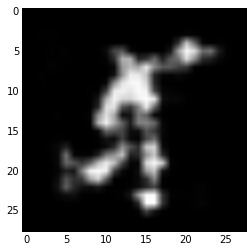

In [10]:
sample_zmb = floatX(np_rng.uniform(-1., 1., size=(100, nz)))
samples = np.asarray(_gen(sample_zmb))
plt.imshow(samples[0].reshape(28,28),'gray')

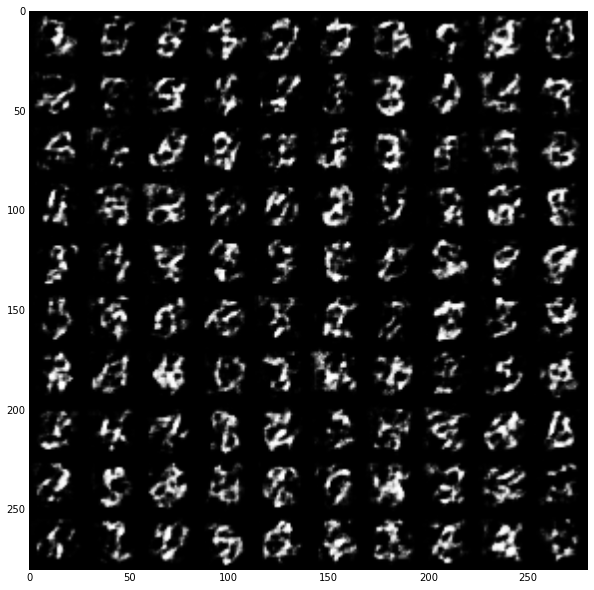

In [9]:
%matplotlib inline
n = 10  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np_rng.uniform(-1., 1., size=(100, nz))
        z_sample=z_sample.astype(np.float32)
        x_decoded = _gen(z_sample)[0]
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,'gray')
plt.show()

(array([ 573.,   10.,   10.,    8.,   16.,    7.,    5.,   13.,   14.,  128.]),
 array([  4.62138674e-19,   9.99975324e-02,   1.99995065e-01,
          2.99992597e-01,   3.99990129e-01,   4.99987662e-01,
          5.99985194e-01,   6.99982727e-01,   7.99980259e-01,
          8.99977791e-01,   9.99975324e-01]),
 <a list of 10 Patch objects>)

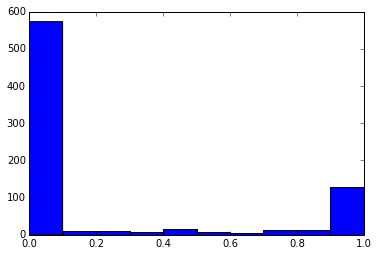

In [128]:
plt.hist(x_decoded.reshape(-1))